**Table of contents**<a id='toc0_'></a>    
- [Imports](#toc1_)    
- [Load data](#toc2_)    
- [Combine in one dataframe](#toc3_)    
- [Make all column names in capital case](#toc4_)    
- [Convert string columns that hold only numbers](#toc5_)    
  - [Get all columns that could be numeric but are string](#toc5_1_)    
  - [Convert truly numeric columns](#toc5_2_)    
- [Create a `selection_set`](#toc6_)    
- [Clean event flag](#toc7_)    
  - [Get all possible outcomes](#toc7_1_)    
  - [`Aircraft Damaged` is in reference paper 1, but not in data](#toc7_2_)    
  - [Aggregate Flag by taking the riskiest outcome](#toc7_3_)    
  - [Plot flag frequencies](#toc7_4_)    
- [Encode empty string entries as new category `NA`](#toc8_)    
- [Saving to files](#toc9_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Imports](#toc0_)

In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle

from controller import Controller

In [2]:
c = Controller('i01')

risk_mapping = {
    4: 'High risk',
    3: 'Moderately high risk',
    2: 'Medium risk',
    1: 'Moderately medium risk',
    0: 'Low risk',
}

result_to_risk = {
    'General Declared Emergency': 4,
    'General Physical Injury Incapacitation': 4,
    'Flight Crew Inflight Shutdown': 4,
    'Air Traffic Control Separated Traffic': 4,
    'Aircraft Aircraft Damaged': 4,
    
    'General Evacuated': 3,
    'Flight Crew Regained Aircraft Control': 3,
    'Air Traffic Control Issued Advisory Alert': 3,
    'Flight Crew Landed in Emergency Condition': 3,
    
    'General Work Refused': 2,
    'Flight Crew Became Reoriented': 2,
    'Flight Crew Diverted': 2,
    'Flight Crew Executed Go Around Missed Approach': 2,
    'Flight Crew Overcame Equipment Problem': 2,
    'Flight Crew Rejected Takeoff': 2,
    'Flight Crew Took Evasive Action': 2,
    'Air Traffic Control Issued New Clearance': 2,
    
    'General Maintenance Action': 1,
    'General Flight Cancelled Delayed': 1,
    'General Release Refused Aircraft Not Accepted': 1,
    'Flight Crew Overrode Automation': 1,
    'Flight Crew FLC Overrode Automation': 1,
    'Flight Crew Exited Penetrated Airspace': 1,
    'Flight Crew Landed As Precaution': 1,
    'Flight Crew Requested ATC Assistance Clarification': 1,
    'Flight Crew Returned To Clearance': 1,
    'Flight Crew Returned To Departure Airport': 1,
    'Aircraft Automation Overrode Flight Crew': 1,
    
    'General Police Security Involved': 0,
    'Flight Crew Returned To Gate': 0,
    'Aircraft Equipment Problem Dissipated': 0,
    'Air Traffic Control Provided Assistance': 0,
    'General None Reported Taken': 0,
    'Flight Crew FLC complied w Automation Advisory': 0,
    
    # These are not discussed in reference paper 1.
    # Below mapping not based on expert opinion.
    'Aircraft Lost Unrecoverable (UAS)': 4,
    'Aircraft Lost Link (UAS)': 2,
    'Aircraft Automated Return to Home (UAS)': 1,
    'Flight Crew Returned to Home (UAS)': 1,
    
    # Encode the empty string as "Low risk".
    '': 0,
}

# <a id='toc2_'></a>[Load data](#toc0_)

In [3]:
filepath = fr'{c.get_path_data_original()}/asrs-aviation-reports-train.jsonl'
df_train = pd.read_json(path_or_buf=filepath, lines=True)
print(f'{df_train.shape=}')

filepath = fr'{c.get_path_data_original()}/asrs-aviation-reports-test.jsonl'
df_test = pd.read_json(path_or_buf=filepath, lines=True)
print(f'{df_test.shape=}')

filepath = fr'{c.get_path_data_original()}/asrs-aviation-reports-validation.jsonl'
df_validation = pd.read_json(path_or_buf=filepath, lines=True)
print(f'{df_validation.shape=}')

df_train.shape=(38655, 111)
df_test.shape=(4773, 111)
df_validation.shape=(4295, 111)


# <a id='toc3_'></a>[Combine in one dataframe](#toc0_)

In [4]:
df_train['train_val_test_split'] = 'Train'
df_test['train_val_test_split'] = 'Test'
df_validation['train_val_test_split'] = 'Validation'

df_train_val_test = pd.concat([df_train, df_validation, df_test], ignore_index=True)
print(f'{df_train_val_test.shape=}')

column = 'train_val_test_split'
pd.concat([
    df_train_val_test[column].value_counts(dropna=False),
    df_train_val_test[column].value_counts(dropna=False, normalize=True),
], axis=1, keys=['Total #', 'Total %'])

df_train_val_test.shape=(47723, 112)


,Total #,Total %
Train,38655,0.809987
Test,4773,0.100015
Validation,4295,0.089999


# <a id='toc4_'></a>[Make all column names in capital case](#toc0_)

In [5]:
def clean_column_names(name: str) -> str:
    # convert whitespace and punctuation to an underscore
    name = re.sub(r'[\s\W]+', '_', name)

    # make upper case
    name = name.upper()

    return name

In [6]:
print('############## Before ##############')
print(df_train_val_test.columns)

print()
print('############## After ##############')
print(df_train_val_test.columns.map(clean_column_names))

############## Before ##############
Index(['acn_num_ACN', 'Time_Date', 'Time.1_Local Time Of Day',
       'Place_Locale Reference', 'Place.1_State Reference',
       'Place.2_Relative Position.Angle.Radial',
       'Place.3_Relative Position.Distance.Nautical Miles',
       'Place.4_Altitude.AGL.Single Value',
       'Place.5_Altitude.MSL.Single Value', 'Environment_Flight Conditions',
       ...
       'Events.4_When Detected', 'Events.5_Result',
       'Assessments_Contributing Factors / Situations',
       'Assessments.1_Primary Problem', 'Report 1_Narrative',
       'Report 1.1_Callback', 'Report 2_Narrative', 'Report 2.1_Callback',
       'Report 1.2_Synopsis', 'train_val_test_split'],
      dtype='object', length=112)

############## After ##############
Index(['ACN_NUM_ACN', 'TIME_DATE', 'TIME_1_LOCAL_TIME_OF_DAY',
       'PLACE_LOCALE_REFERENCE', 'PLACE_1_STATE_REFERENCE',
       'PLACE_2_RELATIVE_POSITION_ANGLE_RADIAL',
       'PLACE_3_RELATIVE_POSITION_DISTANCE_NAUTICAL_MILE

In [7]:
df_train_val_test.columns = df_train_val_test.columns.map(clean_column_names)
df_train_val_test

,ACN_NUM_ACN,TIME_DATE,TIME_1_LOCAL_TIME_OF_DAY,PLACE_LOCALE_REFERENCE,PLACE_1_STATE_REFERENCE,PLACE_2_RELATIVE_POSITION_ANGLE_RADIAL,PLACE_3_RELATIVE_POSITION_DISTANCE_NAUTICAL_MILES,PLACE_4_ALTITUDE_AGL_SINGLE_VALUE,PLACE_5_ALTITUDE_MSL_SINGLE_VALUE,ENVIRONMENT_FLIGHT_CONDITIONS,...,EVENTS_4_WHEN_DETECTED,EVENTS_5_RESULT,ASSESSMENTS_CONTRIBUTING_FACTORS_SITUATIONS,ASSESSMENTS_1_PRIMARY_PROBLEM,REPORT_1_NARRATIVE,REPORT_1_1_CALLBACK,REPORT_2_NARRATIVE,REPORT_2_1_CALLBACK,REPORT_1_2_SYNOPSIS,TRAIN_VAL_TEST_SPLIT
0,1574675,201808,0601-1200,SNA.Airport,CA,,,,5000.0,,...,In-flight,Air Traffic Control Issued New Clearance; Flig...,Human Factors,Human Factors,SNA RNP-Z to Runway 20R. The FMC was properly ...,,We were cleared for the RNP RNAV Z 20R Approac...,,B737-700 flight crew reported failing to make ...,Train
1,1224894,201412,0601-1200,MSY.Airport,LA,,,1000.0,,VMC,...,In-flight,General None Reported / Taken,Human Factors,Human Factors,On base to final turn to runway 1 in MSY at ap...,,,,Captain reports sighting of a drone at 1;000 f...,Train
2,1134202,201312,1201-1800,ZZZ.ARTCC,US,,,,2600.0,IMC,...,In-flight,Air Traffic Control Provided Assistance; Air T...,Human Factors; Aircraft; Procedure; Weather,Aircraft,I climbed to my filed altitude of 5;000 FT; an...,,,,SR22 pilot became disoriented on approach in I...,Train
3,1222074,201411,1201-1800,CWA.Airport,WI,,20.0,,4000.0,,...,In-flight,Flight Crew Became Reoriented; General Mainten...,Aircraft,Aircraft,I had my pitot heat checked prior to winter an...,,,,BE58 pilot experiences pitot heat failure desc...,Train
4,1733019,202003,1801-2400,ZDV.ARTCC,CO,,,,32000.0,,...,In-flight,Air Traffic Control Issued New Clearance; Flig...,Airspace Structure; Weather,Weather,At 32000 ft. just north of PUB the aircraft ex...,,,,B737 First Officer reported unexpected moderat...,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47718,1341108,201603,0601-1200,ZZZ.Airport,US,,,,,IMC,...,In-flight,Air Traffic Control Provided Assistance; Fligh...,Company Policy; Human Factors,Human Factors,We did an originator out of ZZZ and had a main...,,[Report narrative contained no additional info...,,CRJ-900 flight crew reported being dispatched ...,Test
47719,1087474,201305,1201-1800,PHX.Airport,AZ,,,,8000.0,VMC,...,In-flight,Air Traffic Control Issued Advisory / Alert; F...,Aircraft; Human Factors; Procedure,Ambiguous,PHX takeoff Runway 25R flaps 5. CLEARANCE: MAX...,,There was an Airbus that departed before us an...,,CE750 flight crew departing PHX Runway 25R on ...,Test
47720,1756601,202008,,,,,,0.0,,,...,,General None Reported / Taken,Environment - Non Weather Related; Company Pol...,Company Policy,I was scheduled to complete the one day traini...,,,,Air carrier First Officer reported that re-qua...,Test
47721,1102938,201307,0601-1200,MEM.Airport,TN,,,,,VMC,...,In-flight,Air Traffic Control Issued New Clearance; Flig...,Airspace Structure; Chart Or Publication; Proc...,Human Factors,We departed Runway 36C in MEM via the GOETZ TW...,,,,On initial climb out via the GOETZ RNAV SID fr...,Test


# <a id='toc5_'></a>[Convert string columns that hold only numbers](#toc0_)

## <a id='toc5_1_'></a>[Get all columns that could be numeric but are string](#toc0_)

In [8]:
can_be_numeric = []

for col in df_train_val_test.columns:
    try:
        pd.to_numeric(df_train_val_test[col])
    except ValueError:
        pass
    else:
        can_be_numeric.append(col)
    
can_be_numeric

['ACN_NUM_ACN',
 'TIME_DATE',
 'PLACE_2_RELATIVE_POSITION_ANGLE_RADIAL',
 'PLACE_3_RELATIVE_POSITION_DISTANCE_NAUTICAL_MILES',
 'PLACE_4_ALTITUDE_AGL_SINGLE_VALUE',
 'PLACE_5_ALTITUDE_MSL_SINGLE_VALUE',
 'AIRCRAFT_1_4_CREW_SIZE',
 'AIRCRAFT_1_19_NUMBER_OF_SEATS_NUMBER',
 'AIRCRAFT_1_20_PASSENGERS_ON_BOARD_NUMBER',
 'AIRCRAFT_1_21_CREW_SIZE_FLIGHT_ATTENDANT_NUMBER_OF_CREW',
 'AIRCRAFT_2_4_CREW_SIZE',
 'PERSON_1_10_ASRS_REPORT_NUMBER_ACCESSION_NUMBER',
 'PERSON_2_10_ASRS_REPORT_NUMBER_ACCESSION_NUMBER']

## <a id='toc5_2_'></a>[Convert truly numeric columns](#toc0_)

In [9]:
# 'ACN_NUM_ACN' - not converted, unique identifier
# 'TIME_DATE' - not converted, does not seem useful
# 'PERSON_1_10_ASRS_REPORT_NUMBER_ACCESSION_NUMBER' - not converted, unique identifier
# 'PERSON_2_10_ASRS_REPORT_NUMBER_ACCESSION_NUMBER' - not converted, unique identifier

convert_to_numeric = [
    'PLACE_2_RELATIVE_POSITION_ANGLE_RADIAL',
    'PLACE_3_RELATIVE_POSITION_DISTANCE_NAUTICAL_MILES',
    'PLACE_4_ALTITUDE_AGL_SINGLE_VALUE',
    'PLACE_5_ALTITUDE_MSL_SINGLE_VALUE',
    'AIRCRAFT_1_4_CREW_SIZE',
    'AIRCRAFT_1_19_NUMBER_OF_SEATS_NUMBER',
    'AIRCRAFT_1_20_PASSENGERS_ON_BOARD_NUMBER',
    'AIRCRAFT_1_21_CREW_SIZE_FLIGHT_ATTENDANT_NUMBER_OF_CREW',
    'AIRCRAFT_2_4_CREW_SIZE',
]

for col in convert_to_numeric:
    df_train_val_test[col] = pd.to_numeric(df_train_val_test[col])

# <a id='toc6_'></a>[Create a `selection_set`](#toc0_)

In [10]:
selection_set = df_train_val_test.columns.tolist()
selection_set.remove('EVENTS_5_RESULT')
selection_set.remove('TRAIN_VAL_TEST_SPLIT')
len(selection_set)

110

# <a id='toc7_'></a>[Clean event flag](#toc0_)

In [11]:
column = 'EVENTS_5_RESULT'
pd.concat([
    df_train_val_test[column].value_counts(dropna=False),
    df_train_val_test[column].value_counts(dropna=False, normalize=True),
], axis=1, keys=['Total #', 'Total %'])

,Total #,Total %
General None Reported / Taken,7737,0.162123
Flight Crew Took Evasive Action,2776,0.058169
,2296,0.048111
General Maintenance Action,1736,0.036377
Air Traffic Control Issued New Clearance,1121,0.023490
...,...,...
Flight Crew FLC complied w / Automation / Advisory; Flight Crew Landed As Precaution; Flight Crew Returned To Departure Airport; Flight Crew Took Evasive Action,1,0.000021
Air Traffic Control Issued Advisory / Alert; Flight Crew Diverted; Flight Crew Landed As Precaution; General Declared Emergency; General Maintenance Action,1,0.000021
Flight Crew Became Reoriented; Flight Crew FLC Overrode Automation; Flight Crew Landed in Emergency Condition; Flight Crew Regained Aircraft Control,1,0.000021
Air Traffic Control Issued New Clearance; Air Traffic Control Issued Advisory / Alert; Flight Crew Took Evasive Action; Flight Crew Returned To Clearance; Flight Crew Regained Aircraft Control; Flight Crew Executed Go Around / Missed Approach,1,0.000021


In [12]:
df_train_val_test.query('EVENTS_5_RESULT == ""')['TRAIN_VAL_TEST_SPLIT'].value_counts()

Train         1837
Test           252
Validation     207
Name: TRAIN_VAL_TEST_SPLIT, dtype: int64

In [13]:
def clean_even_outcome(outcome):
    # remove all "/" characters
    outcome = outcome.replace('/', '')
    
    # replace all whitespace characters with a single space
    outcome = re.sub(r'[\s]+', ' ', outcome)
    
    # split on the ";" character
    outcomes = outcome.split('; ')
    
    return outcomes

In [14]:
print('############## EVENTS_5_RESULT ##############')
print(df_train_val_test['EVENTS_5_RESULT'])

print()
print('############## EVENTS_5_RESULT_CLEAN ##############')
df_train_val_test['EVENTS_5_RESULT_CLEAN'] = df_train_val_test['EVENTS_5_RESULT'].map(clean_even_outcome)
print(df_train_val_test['EVENTS_5_RESULT_CLEAN'])

############## EVENTS_5_RESULT ##############
0        Air Traffic Control Issued New Clearance; Flig...
1                            General None Reported / Taken
2        Air Traffic Control Provided Assistance; Air T...
3        Flight Crew Became Reoriented; General Mainten...
4        Air Traffic Control Issued New Clearance; Flig...
                               ...                        
47718    Air Traffic Control Provided Assistance; Fligh...
47719    Air Traffic Control Issued Advisory / Alert; F...
47720                        General None Reported / Taken
47721    Air Traffic Control Issued New Clearance; Flig...
47722    General Flight Cancelled / Delayed; General Ma...
Name: EVENTS_5_RESULT, Length: 47723, dtype: object

############## EVENTS_5_RESULT_CLEAN ##############
0        [Air Traffic Control Issued New Clearance, Fli...
1                            [General None Reported Taken]
2        [Air Traffic Control Provided Assistance, Air ...
3        [Flight Crew B

## <a id='toc7_1_'></a>[Get all possible outcomes](#toc0_)

In [15]:
sorted(list(set(elem for sublist in df_train_val_test['EVENTS_5_RESULT_CLEAN'].values.tolist() for elem in sublist)))

['',
 'Air Traffic Control Issued Advisory Alert',
 'Air Traffic Control Issued New Clearance',
 'Air Traffic Control Provided Assistance',
 'Air Traffic Control Separated Traffic',
 'Aircraft Aircraft Damaged',
 'Aircraft Automated Return to Home (UAS)',
 'Aircraft Automation Overrode Flight Crew',
 'Aircraft Equipment Problem Dissipated',
 'Aircraft Lost Link (UAS)',
 'Aircraft Lost Unrecoverable (UAS)',
 'Flight Crew Became Reoriented',
 'Flight Crew Diverted',
 'Flight Crew Executed Go Around Missed Approach',
 'Flight Crew Exited Penetrated Airspace',
 'Flight Crew FLC Overrode Automation',
 'Flight Crew FLC complied w Automation Advisory',
 'Flight Crew Inflight Shutdown',
 'Flight Crew Landed As Precaution',
 'Flight Crew Landed in Emergency Condition',
 'Flight Crew Overcame Equipment Problem',
 'Flight Crew Overrode Automation',
 'Flight Crew Regained Aircraft Control',
 'Flight Crew Rejected Takeoff',
 'Flight Crew Requested ATC Assistance Clarification',
 'Flight Crew Return

## <a id='toc7_2_'></a>[`Aircraft Damaged` is in reference paper 1, but not in data](#toc0_)

In [16]:
'Aircraft Damaged' in df_train_val_test['EVENTS_5_RESULT']

False

## <a id='toc7_3_'></a>[Aggregate Flag by taking the riskiest outcome](#toc0_)

In [17]:
df_train_val_test['EVENT_RISK'] = df_train_val_test['EVENTS_5_RESULT_CLEAN'].map(lambda xs: max([result_to_risk.get(x, -1) for x in xs]))
df_train_val_test['EVENT_RISK_STR'] = df_train_val_test['EVENT_RISK'].map(risk_mapping.get)
df_train_val_test = df_train_val_test.drop(['EVENTS_5_RESULT_CLEAN'], axis=1)

column = 'EVENT_RISK_STR'
flag_frequencies = pd.concat([
    df_train_val_test[column].value_counts(dropna=False),
    df_train_val_test[column].value_counts(dropna=False, normalize=True),
], axis=1, keys=['# Total', '% Total'])
flag_frequencies = flag_frequencies.reindex(reversed(risk_mapping.values()))
flag_frequencies

,# Total,% Total
Low risk,10754,0.225342
Moderately medium risk,5755,0.120592
Medium risk,16519,0.346143
Moderately high risk,7346,0.153930
High risk,7349,0.153993


## <a id='toc7_4_'></a>[Plot flag frequencies](#toc0_)

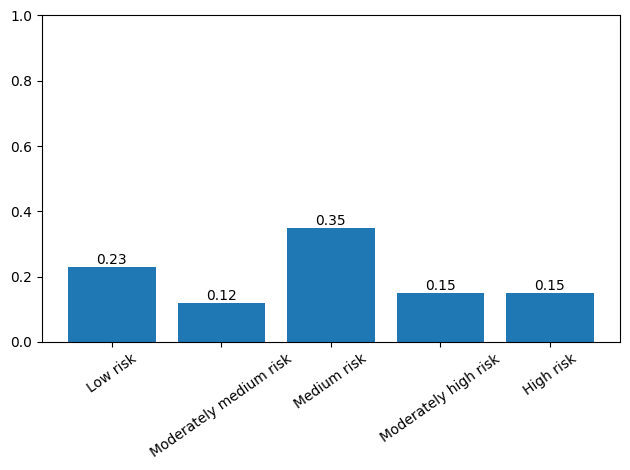

In [18]:
index = flag_frequencies['% Total'].index
values = [round(val, 2) for val in flag_frequencies['% Total'].values]

fig, ax = plt.subplots()

bars = ax.bar(index, values)

ax.tick_params(axis='x', labelrotation=35)
ax.bar_label(bars)
ax.set_ylim([0, 1])

plt.tight_layout()

# <a id='toc8_'></a>[Encode empty string entries as new category `NA`](#toc0_)

In [19]:
df_train_val_test = df_train_val_test.applymap(lambda value: 'NA' if isinstance(value, str) and value == '' else value)
df_train_val_test

,ACN_NUM_ACN,TIME_DATE,TIME_1_LOCAL_TIME_OF_DAY,PLACE_LOCALE_REFERENCE,PLACE_1_STATE_REFERENCE,PLACE_2_RELATIVE_POSITION_ANGLE_RADIAL,PLACE_3_RELATIVE_POSITION_DISTANCE_NAUTICAL_MILES,PLACE_4_ALTITUDE_AGL_SINGLE_VALUE,PLACE_5_ALTITUDE_MSL_SINGLE_VALUE,ENVIRONMENT_FLIGHT_CONDITIONS,...,ASSESSMENTS_CONTRIBUTING_FACTORS_SITUATIONS,ASSESSMENTS_1_PRIMARY_PROBLEM,REPORT_1_NARRATIVE,REPORT_1_1_CALLBACK,REPORT_2_NARRATIVE,REPORT_2_1_CALLBACK,REPORT_1_2_SYNOPSIS,TRAIN_VAL_TEST_SPLIT,EVENT_RISK,EVENT_RISK_STR
0,1574675,201808,0601-1200,SNA.Airport,CA,NaN,NaN,NaN,5000.0,NA,...,Human Factors,Human Factors,SNA RNP-Z to Runway 20R. The FMC was properly ...,NA,We were cleared for the RNP RNAV Z 20R Approac...,NA,B737-700 flight crew reported failing to make ...,Train,2,Medium risk
1,1224894,201412,0601-1200,MSY.Airport,LA,NaN,NaN,1000.0,NaN,VMC,...,Human Factors,Human Factors,On base to final turn to runway 1 in MSY at ap...,NA,NA,NA,Captain reports sighting of a drone at 1;000 f...,Train,0,Low risk
2,1134202,201312,1201-1800,ZZZ.ARTCC,US,NaN,NaN,NaN,2600.0,IMC,...,Human Factors; Aircraft; Procedure; Weather,Aircraft,I climbed to my filed altitude of 5;000 FT; an...,NA,NA,NA,SR22 pilot became disoriented on approach in I...,Train,3,Moderately high risk
3,1222074,201411,1201-1800,CWA.Airport,WI,NaN,20.0,NaN,4000.0,NA,...,Aircraft,Aircraft,I had my pitot heat checked prior to winter an...,NA,NA,NA,BE58 pilot experiences pitot heat failure desc...,Train,2,Medium risk
4,1733019,202003,1801-2400,ZDV.ARTCC,CO,NaN,NaN,NaN,32000.0,NA,...,Airspace Structure; Weather,Weather,At 32000 ft. just north of PUB the aircraft ex...,NA,NA,NA,B737 First Officer reported unexpected moderat...,Train,3,Moderately high risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47718,1341108,201603,0601-1200,ZZZ.Airport,US,NaN,NaN,NaN,NaN,IMC,...,Company Policy; Human Factors,Human Factors,We did an originator out of ZZZ and had a main...,NA,[Report narrative contained no additional info...,NA,CRJ-900 flight crew reported being dispatched ...,Test,3,Moderately high risk
47719,1087474,201305,1201-1800,PHX.Airport,AZ,NaN,NaN,NaN,8000.0,VMC,...,Aircraft; Human Factors; Procedure,Ambiguous,PHX takeoff Runway 25R flaps 5. CLEARANCE: MAX...,NA,There was an Airbus that departed before us an...,NA,CE750 flight crew departing PHX Runway 25R on ...,Test,3,Moderately high risk
47720,1756601,202008,NA,NA,NA,NaN,NaN,0.0,NaN,NA,...,Environment - Non Weather Related; Company Pol...,Company Policy,I was scheduled to complete the one day traini...,NA,NA,NA,Air carrier First Officer reported that re-qua...,Test,0,Low risk
47721,1102938,201307,0601-1200,MEM.Airport,TN,NaN,NaN,NaN,NaN,VMC,...,Airspace Structure; Chart Or Publication; Proc...,Human Factors,We departed Runway 36C in MEM via the GOETZ TW...,NA,NA,NA,On initial climb out via the GOETZ RNAV SID fr...,Test,2,Medium risk


<Axes: >

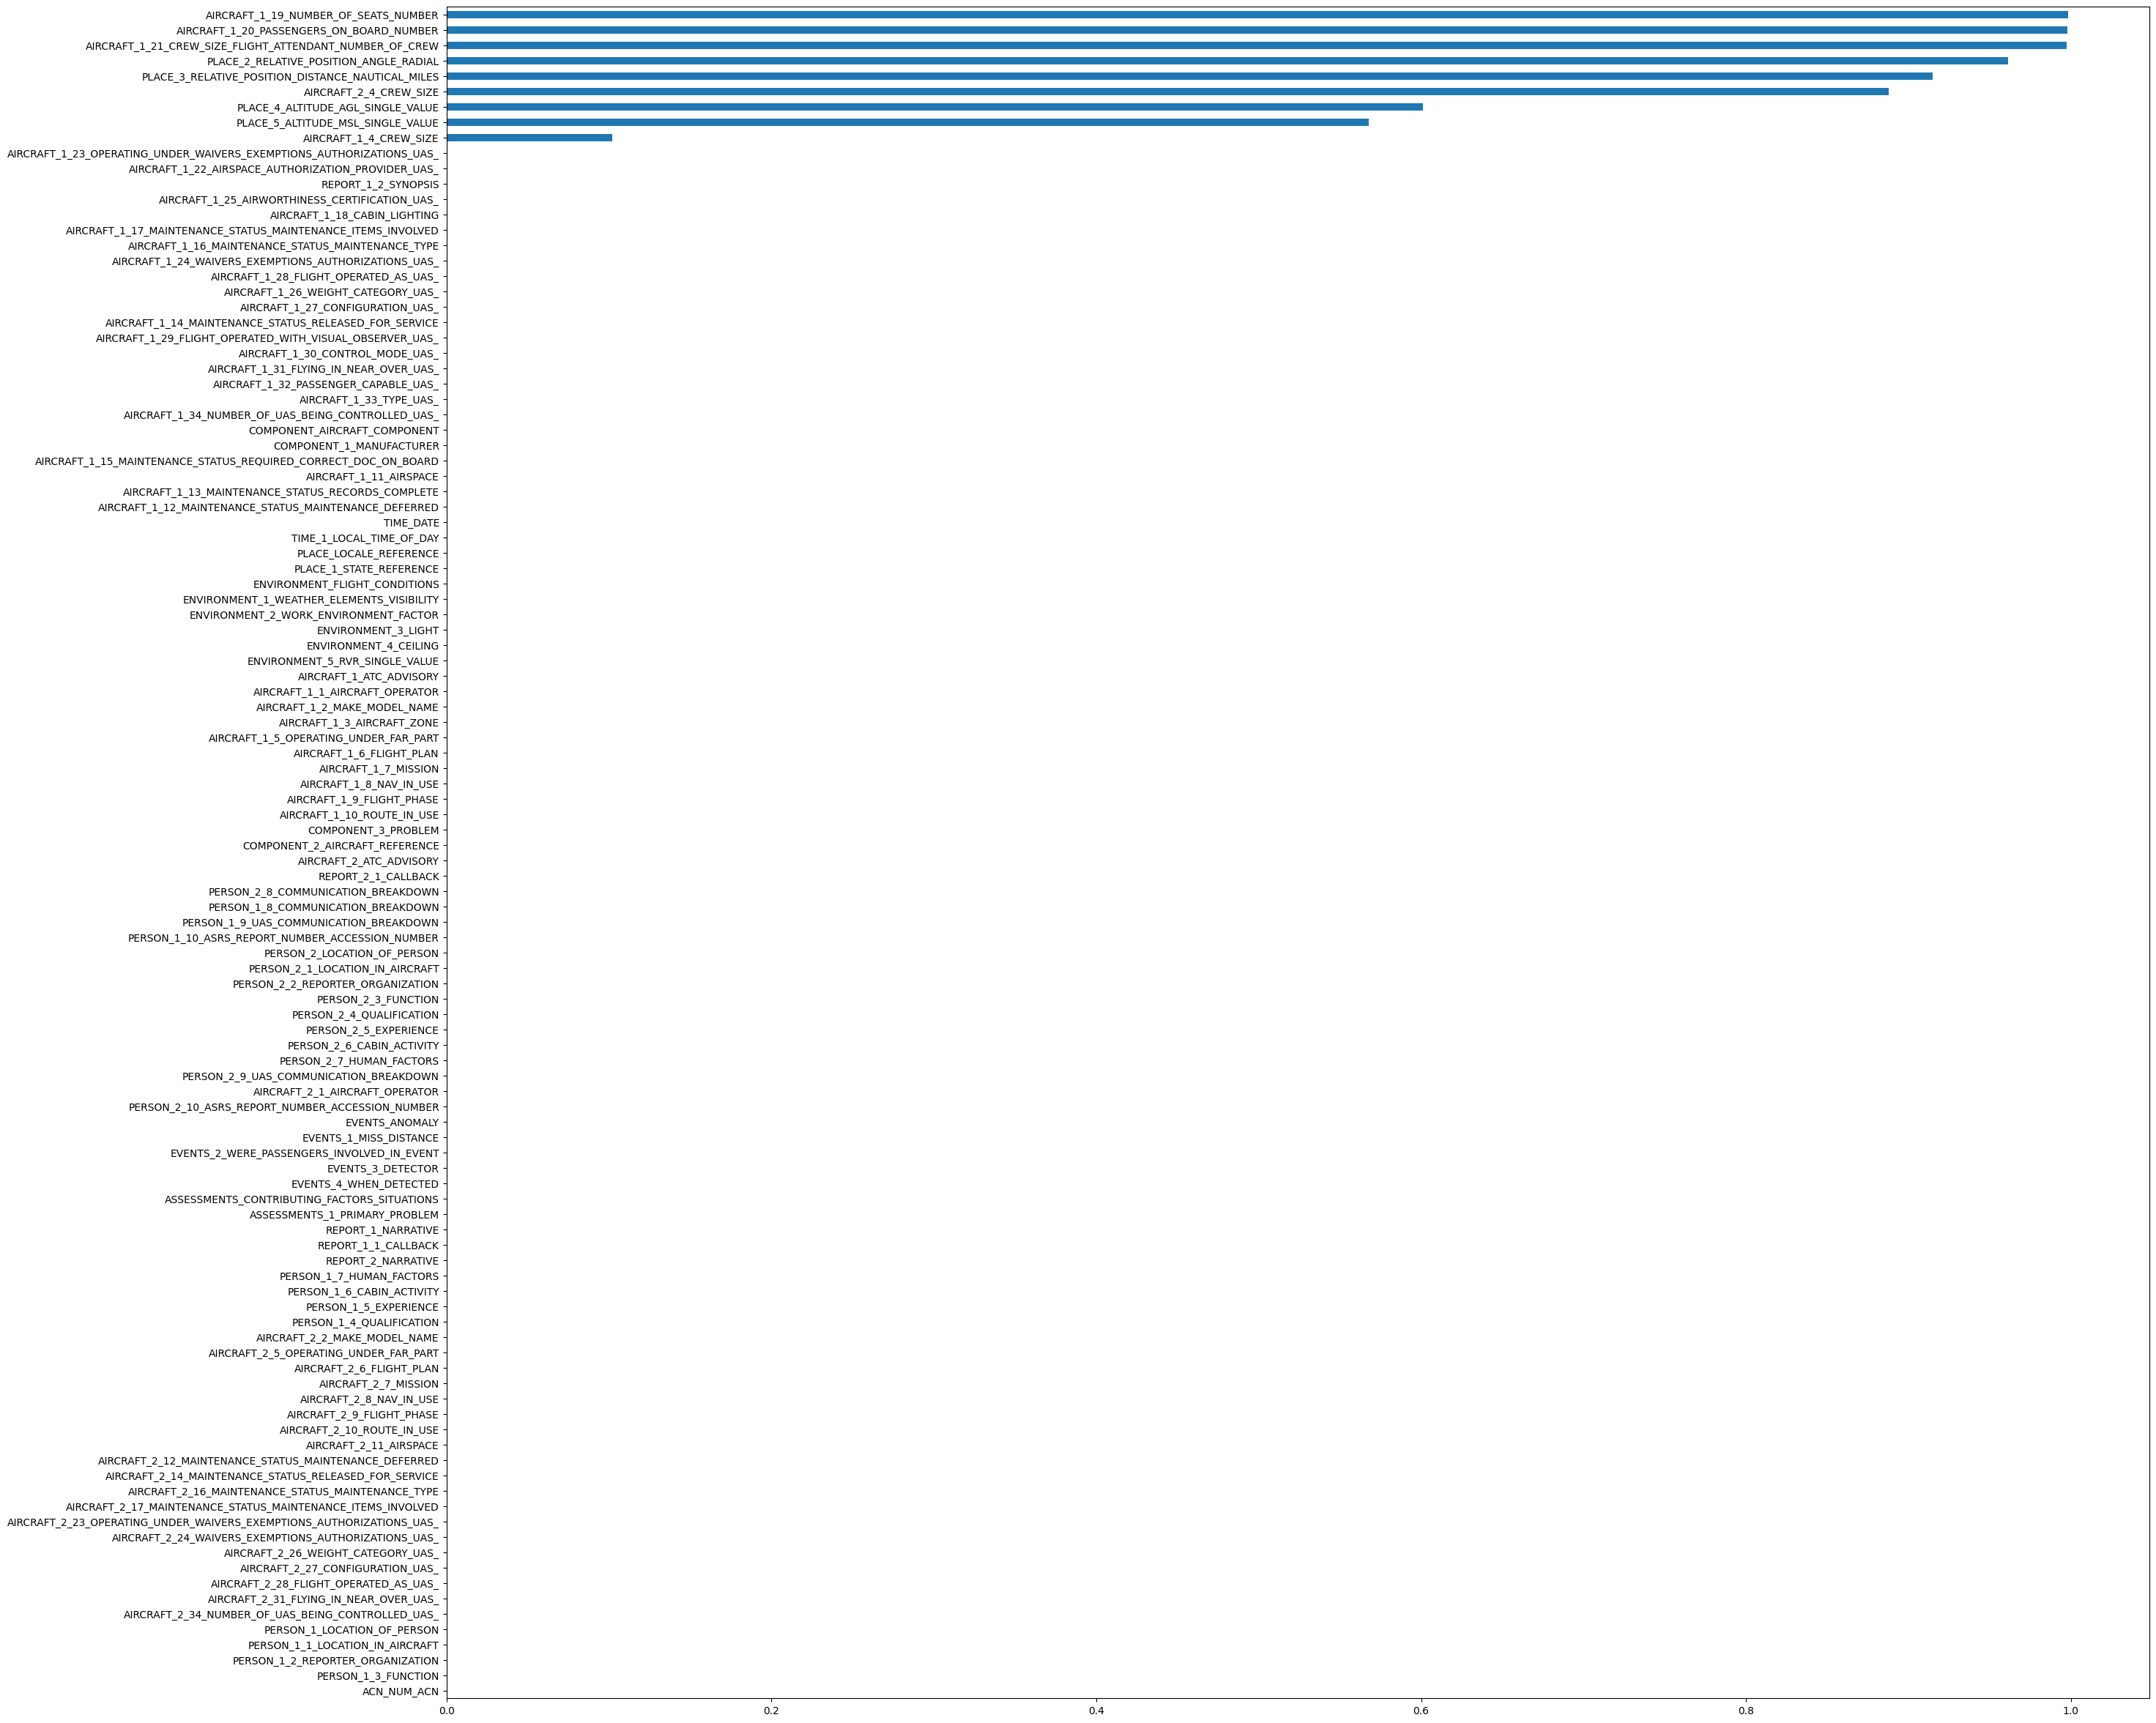

In [20]:
# Most of the features are completely missing.
df_train_val_test[selection_set].isna().mean().sort_values().plot(kind='barh', figsize=(30, 30))

# <a id='toc9_'></a>[Saving to files](#toc0_)

In [21]:
filepath = fr'{c.get_path_data_prepared()}/01_df_train_val_test.pkl'
df_train_val_test.to_pickle(filepath)

In [ ]:
filepath = fr'{c.get_path_iteration()}/{c.iteration}_ss.pkl'
with open(filepath, 'wb') as f:
    pickle.dump(selection_set, f)